# Trend Following Box Rate

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\BoxSpreadKalmanTreasury\root\src")
from SignalGenerator import SignalGenerator

## Box Rate

### Get Data

In [3]:
def get_data() -> pd.DataFrame:
    
    df_fut = SignalGenerator().get_tsy_fut()

    df_signal = (SignalGenerator().get_trend().query(
        "data_source == 'box'").
        drop(columns = ["data_source"]))
    
    return df_fut, df_signal

df_fut, df_signal = get_data()

### Signal Analysis

First start with the correlation matrix of all of the signals across each other

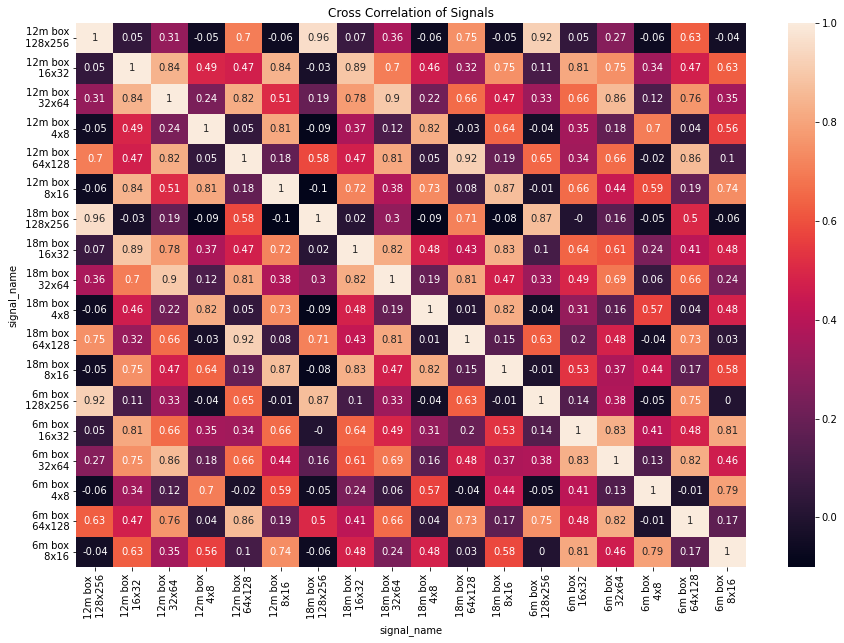

In [4]:
def plot_correlation(df_signal: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (15,10))

    df_corr = (df_signal.sort_values(
        ["short_window", "long_window"]).
        assign(signal_name = lambda x: x.group_var + "\n " + x.short_window.astype(str) + "x" + x.long_window.astype(str))
        [["date", "signal_name", "lag_signal"]].
        pivot(index = "date", columns = "signal_name", values = "lag_signal").
        tail(2_000).
        corr().
        apply(lambda x: np.round(x,2)))

    sns.heatmap(
        data  = df_corr,
        annot = True,
        ax    = axes)
    
    axes.set_title("Cross Correlation of Signals")
    
plot_correlation(df_signal)

## Backtest

In [35]:
def get_signal_rtn(df_signal: pd.DataFrame, df_fut: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_signal[
        ["date", "variable", "group_var", "short_window", "long_window", "lag_signal"]])

    df_rtn = (df_fut.merge(
        right = df_tmp, how = "inner", on = ["date"]).
        assign(
            signal_bps = lambda x: np.sign(x.lag_signal) * x.PX_BPS,
            strat_name = lambda x: x.short_window.astype(str) + "x" + x.long_window.astype(str)).
        drop(columns = ["short_window", "long_window"]))
    
    return df_rtn

df_signal_rtn = get_signal_rtn(df_signal, df_fut)

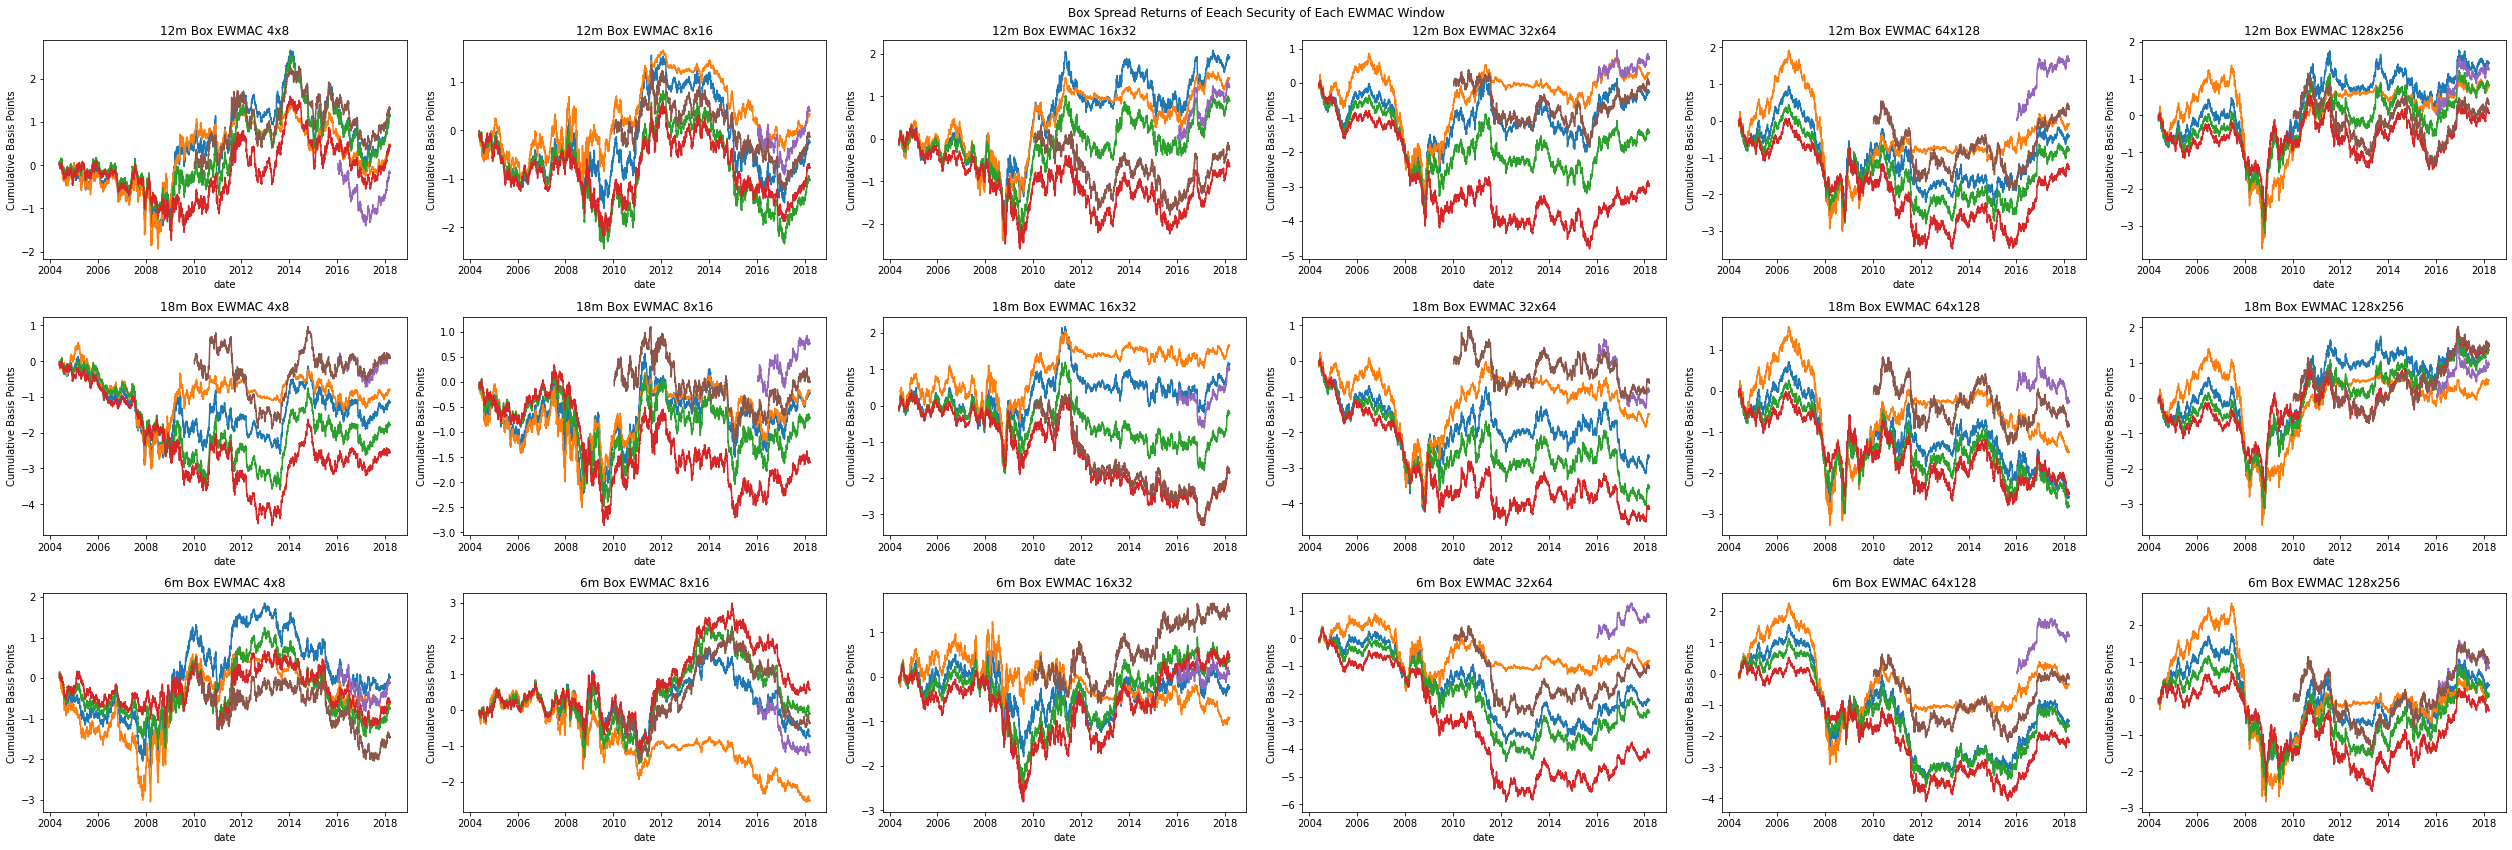

In [62]:
def plot_individual_performance(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    df_prep = (df_signal_rtn.assign(
        strat_name = lambda x: x.group_var.str.replace("b", "B") + " EWMAC " + x.strat_name))

    group_vars = df_prep.strat_name.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 3, nrows = len(group_vars) // 6, figsize = (35,12))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_prep.query(
            "strat_name == @group_var")
            [["date", "security", "signal_bps"]].
            pivot(index = "date", columns = "security", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                legend = False,
                ylabel = "Cumulative Basis Points",
                title  = group_var))

    fig.suptitle("Box Spread Returns of Eeach Security of Each EWMAC Window")
    plt.tight_layout()
    
plot_individual_performance(df_signal_rtn)

Now calculate individual sharpes

In [71]:
def get_individual_sharpe(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_signal_rtn[
        ["security", "group_var", "strat_name", "signal_bps"]].
        groupby(["security", "group_var", "strat_name"]).
        agg(["mean", "std"])
        ["signal_bps"].
        reset_index().
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_sharpe = get_individual_sharpe(df_signal_rtn)

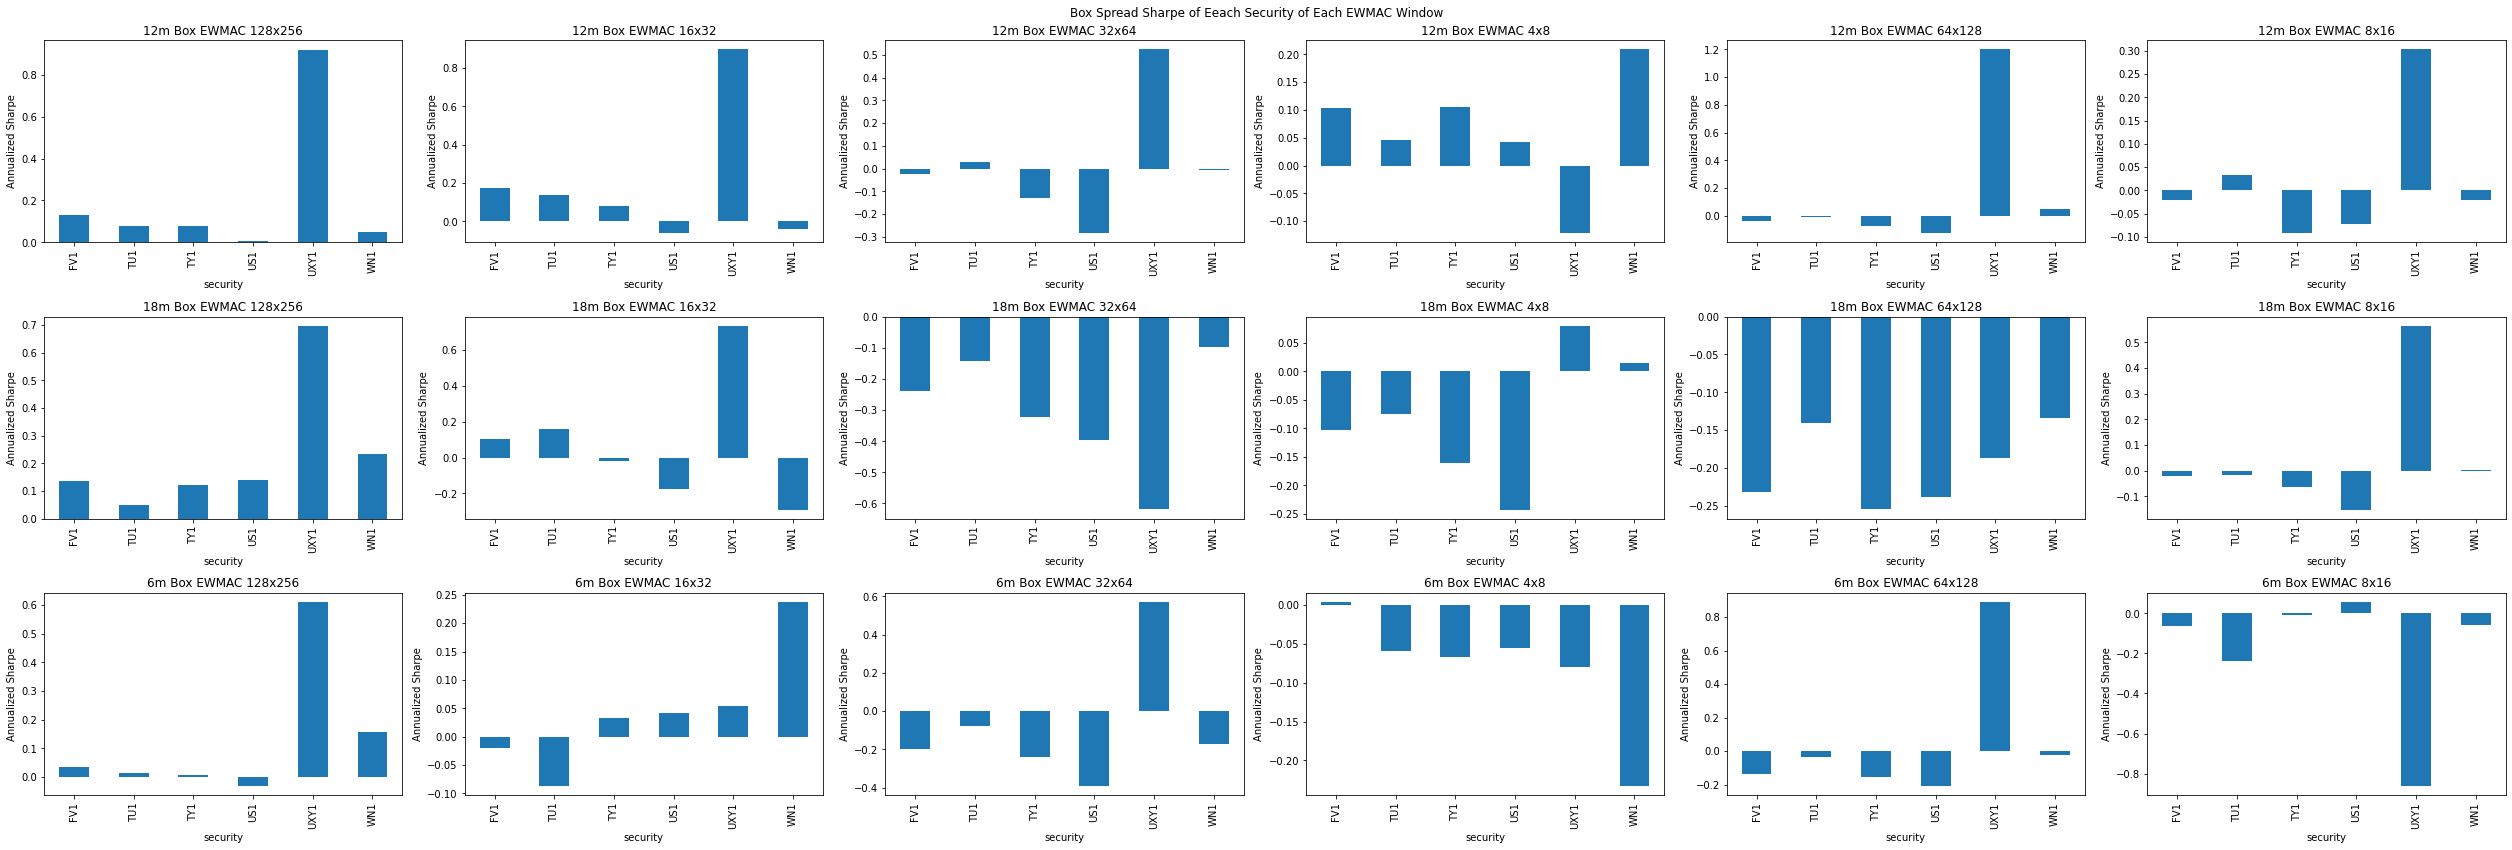

In [81]:
def plot_individual_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_prep = (df_sharpe.assign(
        strat_name = lambda x: x.group_var.str.replace("b", "B") + " EWMAC " + x.strat_name))

    group_vars = df_prep.strat_name.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 3, nrows = len(group_vars) // 6, figsize = (35,12))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_prep.query(
            "strat_name == @group_var")
            [["security", "sharpe"]].
            set_index("security").
            plot(
                ax     = ax,
                legend = False,
                kind   = "bar",
                ylabel = "Annualized Sharpe",
                title  = group_var))

    fig.suptitle("Box Spread Sharpe of Eeach Security of Each EWMAC Window")
    plt.tight_layout()
    
plot_individual_sharpe(df_sharpe)

All of the sharpes are quite poor, outliers like UXY likely occur from some regime that occurs post 2016 and the contract is much newer than the others. 

## Equal Risk Contribution Portfolio

In [113]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_vol = lambda x: x.signal_bps.rolling(window = window).std(),
            lag_vol  = lambda x: x.roll_vol.shift()).
        dropna())
    
    return df_out

def get_erc_weighting(df_singal_rtn: pd.DataFrame, window: int = 30) -> pd.DataFrame: 
    
    df_tmp = (df_signal_rtn.assign(
        tmp = lambda x: x.strat_name + " " + x.security + " " + x.group_var).
        groupby("tmp").
        apply(_get_vol, window).
        reset_index(drop = True).
        assign(inv_vol = lambda x: 1 / x.lag_vol).
        drop(columns = ["tmp"]).
        assign(tmp = lambda x: x.group_var + " " + x.strat_name))

    df_out = (df_tmp[
        ["date", "inv_vol", "tmp"]].
        groupby(["date", "tmp"]).
        agg("sum").
        reset_index().
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_tmp, how = "inner", on = ["date", "tmp"]).
        assign(
            weight       = lambda x: x.lag_vol / x.cum_vol,
            weighted_rtn = lambda x: x.weight * x.signal_bps)
        [["date", "tmp", "weighted_rtn"]].
        groupby(["date", "tmp"]).
        agg("sum").
        reset_index().
        assign(
            indicator  = lambda x: x.tmp.str.split("ox").str[0] + "x",
            strat_name = lambda x: x.tmp.str.split("ox").str[-1].str.strip()))
    
    return df_out

df_erc_port = get_erc_weighting(df_signal_rtn)

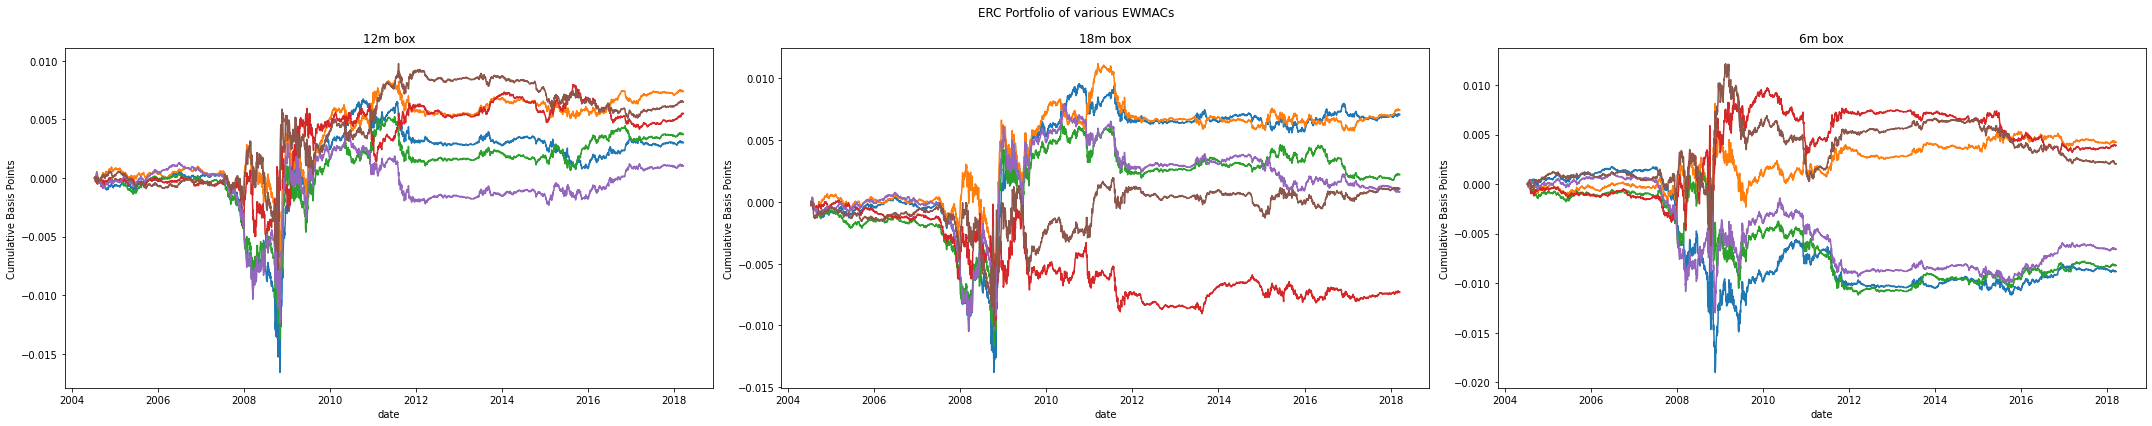

In [129]:
def plot_erc_returns(df_erc_port: pd.DataFrame) -> pd.DataFrame: 
    
    indicators = df_erc_port.indicator.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(indicators), figsize = (30,6))

    for indicator, ax in zip(indicators, axes.flatten()): 

        (df_erc_port.query(
            "indicator == @indicator")
            [["date", "strat_name", "weighted_rtn"]].
            pivot(index = "date", columns = "strat_name", values = "weighted_rtn").
            cumsum().
            plot(
                ax     = ax,
                legend = False,
                title  = indicator.replace("bx", "box"),
                ylabel = "Cumulative Basis Points"))
        
    fig.suptitle("ERC Portfolio of various EWMACs")
    plt.tight_layout()
    
plot_erc_returns(df_erc_port)

In [142]:
def get_erc_sharpe(df_erc_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_erc_port[
        ["indicator", "strat_name", "weighted_rtn"]].
        groupby(["indicator", "strat_name"]).
        agg(["mean", "std"])
        ["weighted_rtn"].
        reset_index().
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_erc_sharpe = get_erc_sharpe(df_erc_port)

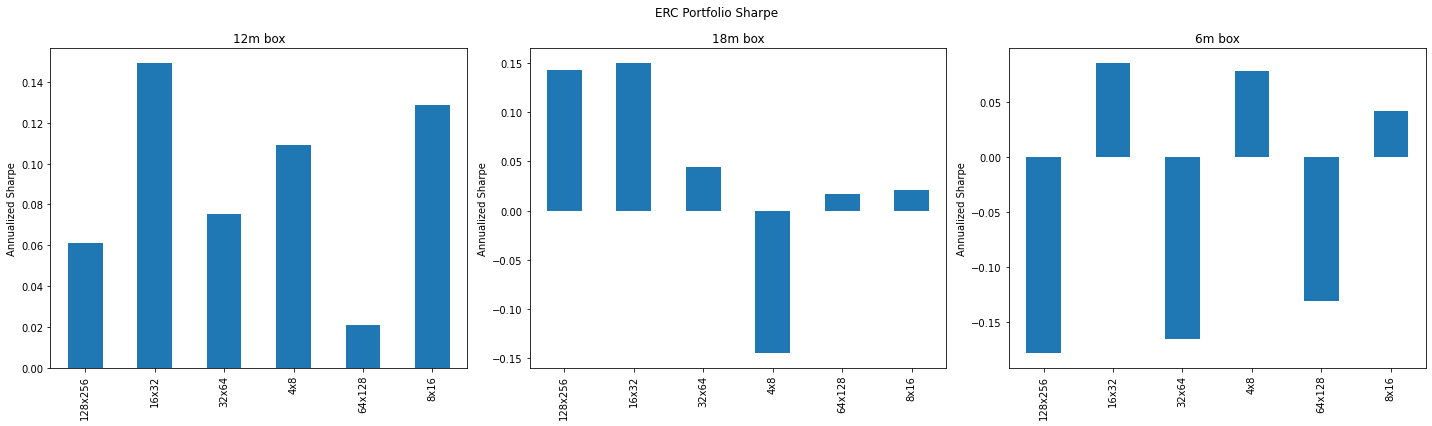

In [150]:
def plot_erc_sharpe(df_erc_port: pd.DataFrame) -> plt.Figure:
    
    indicators = df_erc_port.indicator.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(indicators), figsize = (20,6))

    for indicator, ax in zip(indicators, axes.flatten()): 

        (df_erc_sharpe.query(
            "indicator == @indicator")
            [["strat_name", "sharpe"]].
            set_index("strat_name").
            plot(
                xlabel = "",
                kind   = "bar",
                ax     = ax,
                legend = False,
                title  = indicator.replace("bx", "box"),
                ylabel = "Annualized Sharpe"))

    fig.suptitle("ERC Portfolio Sharpe")
    plt.tight_layout()
    
plot_erc_sharpe(df_erc_port)

The trend following strategies don't work well.